# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [69]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=aa858e44-0b13-4d67-8c29-daf1bd283ad9
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 231MB/s]
replace data/test/5659.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#### Import packages

In [70]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torchsummary import summary
from torchvision import models
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [112]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 102,
    BATCH = 256,
    n_epoch = 15,
    lr = 1e-3,
    weight_decay = 1e-7,
    ckpt_path = 'model.pth',
)

In [113]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

cuda


#### Dataset and Dataloader

In [163]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [170]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=20, scale=(0.90, 1.1)),
    T.ToTensor(),

])
eval_tfm = T.Compose([
    T.ToTensor(),
])

In [171]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

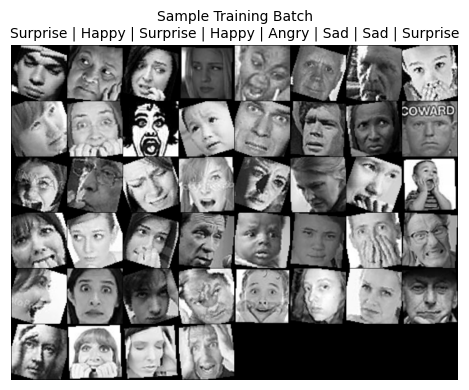

In [172]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(images, labels, classes=None, nrow=8, title="Sample Training Batch"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
        images (Tensor): Batch of images [B, C, H, W]
        labels (Tensor): Corresponding labels [B]
        classes (list, optional): Class names corresponding to label indices.
        nrow (int): Number of images per row in the grid.
        title (str): Title for the plot.
    """
    # Denormalize (if you used normalization in transforms)
    img = images.clone()
    select = [i for i, x in enumerate(labels.tolist()) if x == 2]
    img = img[select]


    # Make grid
    grid = torchvision.utils.make_grid(img, nrow=nrow, padding=2)
    plt.figure(figsize=(nrow * 0.72, nrow * 0.72))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")

    # Add labels below each image
    if classes is not None:
        label_texts = [classes[l.item()] if isinstance(l.item(), int) else str(l) for l in labels[:nrow]]
        plt.title(f"{title}\n" + " | ".join(label_texts), fontsize=10)
    else:
        plt.title(title)

    plt.show()

# Get a batch
images, labels = next(iter(train_loader))

# Define your class names (adjust to your dataset)
classes = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Visualize
show_batch(images, labels, classes=classes)

#### Model

In [179]:
# TODO: define your CNN model
def FaceExpressionNet():
    x = models.resnet18()
    x.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    x.fc = nn.Linear(x.fc.in_features, 7)
    return x

#### training loop

In [177]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.3, patience=3
    )

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        scheduler.step(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training

In [178]:
model = FaceExpressionNet().to(device)

summary(model, (1, 64, 64))
train(model, train_loader, valid_loader, config)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[2, 1, 64, 64] to have 3 channels, but got 1 channels instead

In [ ]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

draw_confusion_matrix(model, valid_loader)


### Testing

In [ ]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)